In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from notebooks.util.distribution_utils import *

from liquidity.response_functions.features import compute_returns
from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

## Load market orders raw sample data

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [5]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,trade_sign,side,lob_action,order_executed,execution_price,execution_size,ask,bid,midprice,ask_volume,bid_volume,price_changing,midprice_change,R1,norm_trade_volume
0,0,2016-01-04 10:30:02.487834868,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
1,1,2016-01-04 10:30:02.594369706,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
2,2,2016-01-04 10:30:02.602151380,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,200.0,100.0,True,-0.095,0.095,0.708122
3,3,2016-01-04 10:30:02.627167275,-1,BID,REMOVE,True,221.27,25,221.36,221.27,221.315,200.0,25.0,True,-0.010,0.010,0.177031
4,4,2016-01-04 10:30:02.895123534,-1,BID,REMOVE,True,221.25,100,221.36,221.25,221.305,100.0,100.0,True,-0.090,0.090,0.708122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757587,757587,2016-12-30 14:57:34.003070849,-1,BID,REMOVE,True,212.66,78,212.71,212.66,212.685,100.0,78.0,True,-0.045,0.045,0.523301
757588,757588,2016-12-30 14:57:49.675498708,1,ASK,REMOVE,True,212.70,100,212.70,212.58,212.640,100.0,3.0,True,0.015,0.015,0.764442
757589,757589,2016-12-30 14:57:50.825570371,1,ASK,REMOVE,True,212.73,118,212.73,212.58,212.655,118.0,3.0,True,-0.005,-0.005,0.902041
757590,757590,2016-12-30 14:58:02.190130229,1,ASK,REMOVE,True,212.72,100,212.72,212.58,212.650,100.0,3.0,True,0.035,0.035,0.764442


## 1. Returns

In [6]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# returns = {stock: data.head(1000000) for stock, data in returns.items()}

### 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [7]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.78
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.00
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.79
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 1.2. Plot returns density functions

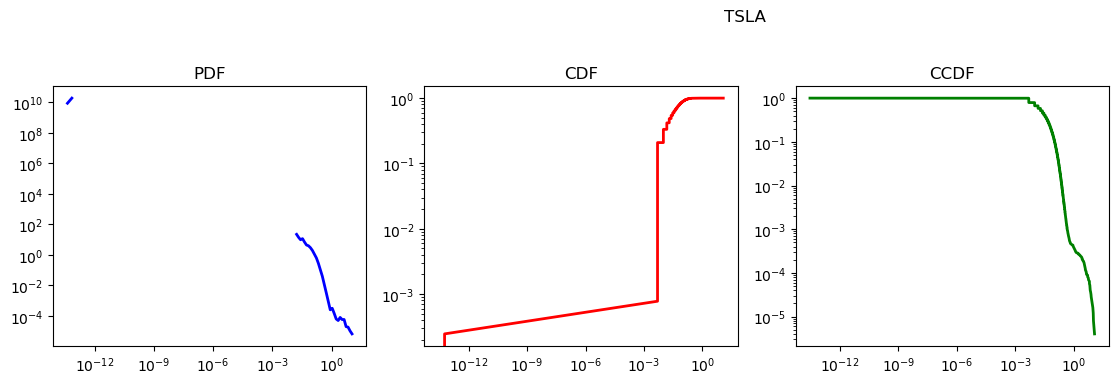

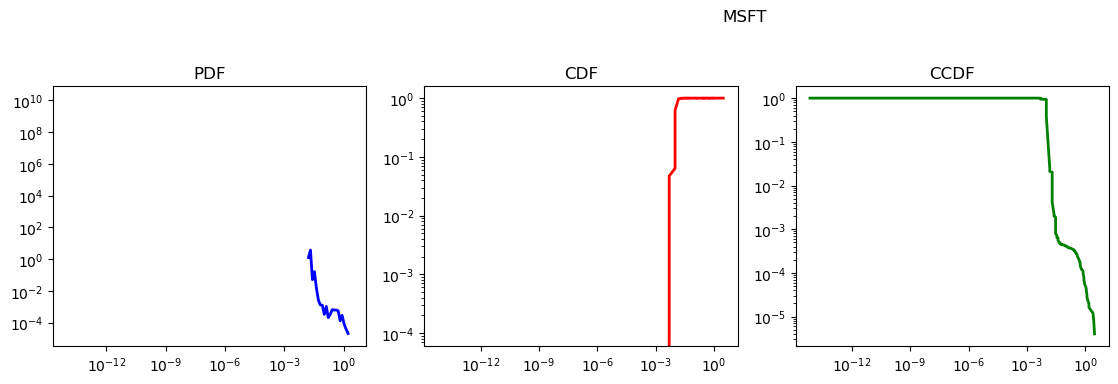

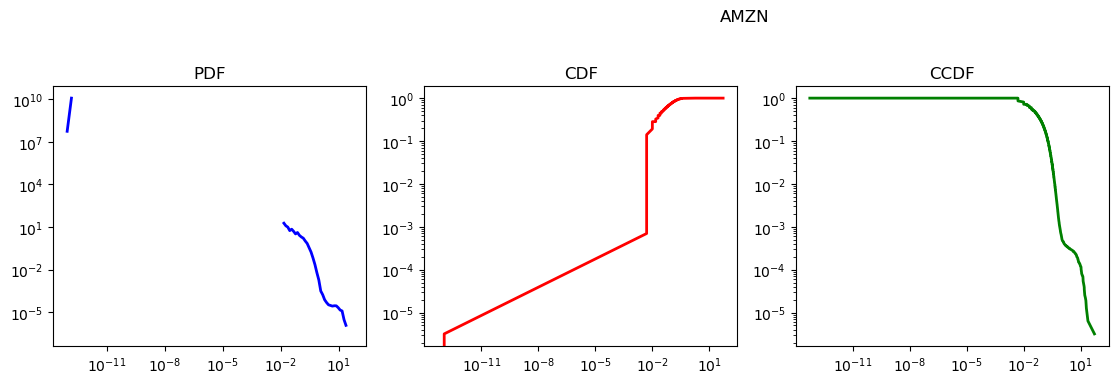

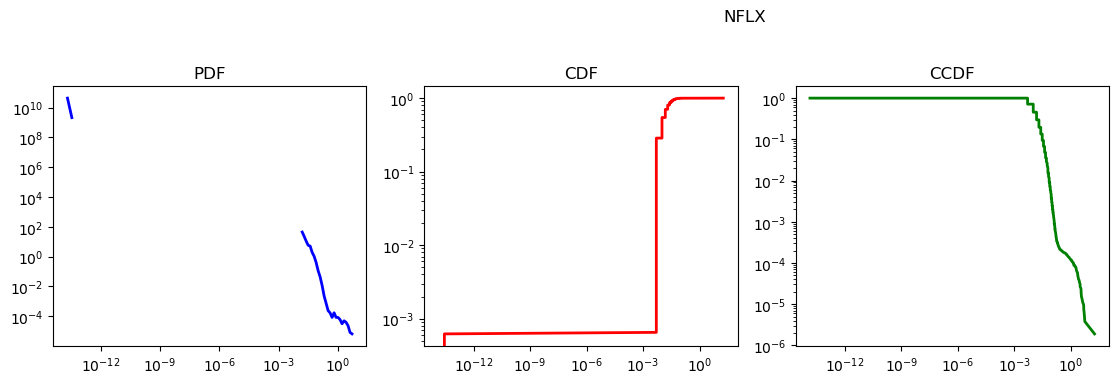

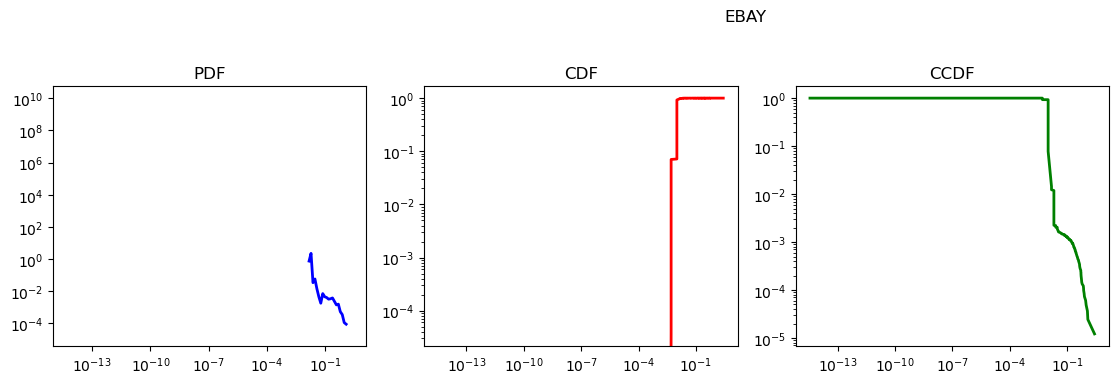

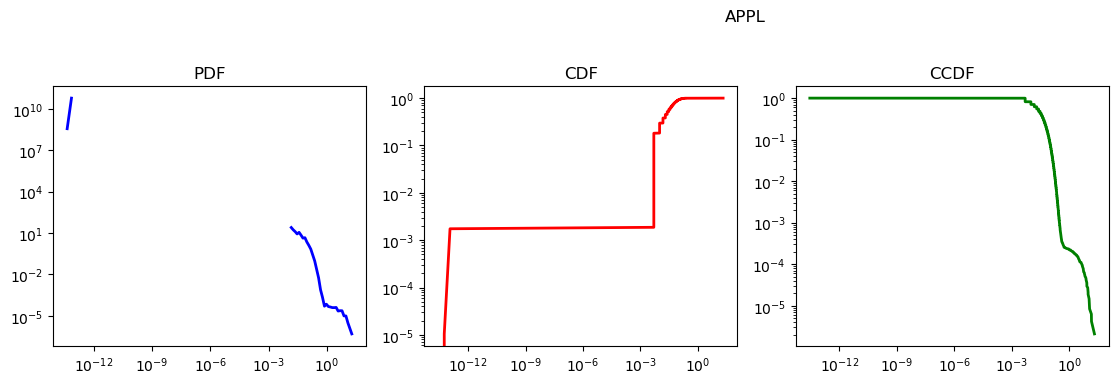

In [8]:
# Plot for each stock
for stock_name, data in returns.items():
    plot_distributions(stock_name, data)

### 1.3. Fit returns power law distribution

In [9]:
# 1. Fit Powerlaw and retrieve fitted object/ results
returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_returns_distributions.pkl')

if not os.path.exists(returns_distributions_data):
    returns_fit_objects = fit_powerlaw(data_dict=returns, filename=returns_distributions_data)
else:
    returns_fit_objects = load_fit_objects(returns_distributions_data)

returns_fit_objects

{'TSLA': <powerlaw.Fit at 0x2d974d650>,
 'MSFT': <powerlaw.Fit at 0x17b6c7010>,
 'AMZN': <powerlaw.Fit at 0x17b6bdcd0>,
 'NFLX': <powerlaw.Fit at 0x17b666210>,
 'EBAY': <powerlaw.Fit at 0x2d7620810>,
 'APPL': <powerlaw.Fit at 0x17b5b6250>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

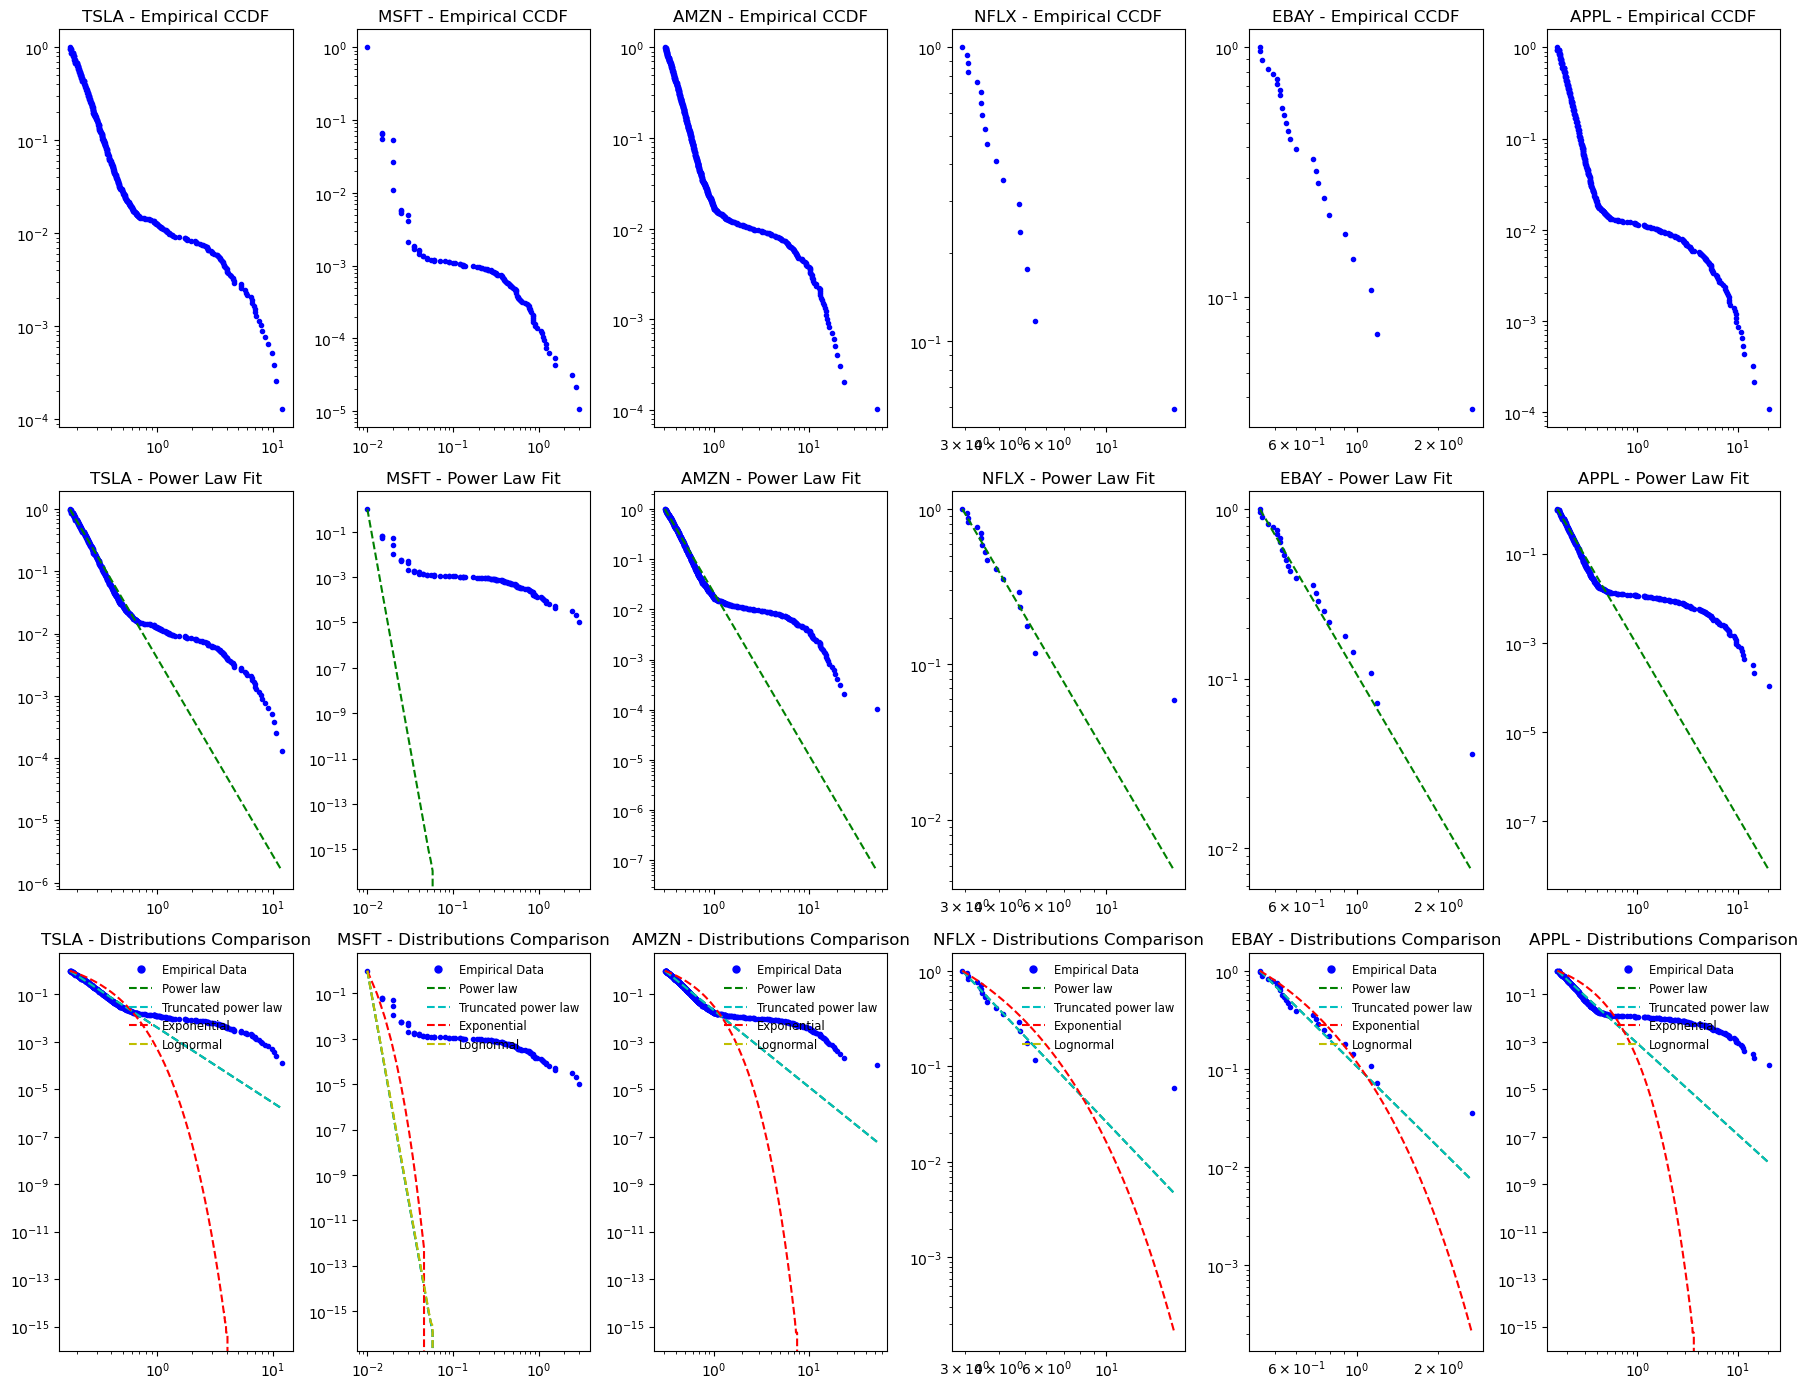

In [10]:
# Plot fitted objects
plot_fit_objects(returns_fit_objects)

#### 1.3.1. Retrieve returns power law fitting results

In [11]:
# Get fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'power_law')
print(returns_power_results)

  Stock Distribution      alpha   xmin  KS Distance
0  TSLA    power_law   4.166712  0.175     0.047110
1  MSFT    power_law  22.033504  0.010     0.065830
2  AMZN    power_law   4.225215  0.305     0.031460
3  NFLX    power_law   3.974212  2.940     0.079087
4  EBAY    power_law   3.732640  0.440     0.081979
5  APPL    power_law   4.840474  0.160     0.054787


In [12]:
# Average Alpha exponents across stocks
min_alpha = returns_power_results['alpha'].min()
max_alpha = returns_power_results['alpha'].max()
avg_alpha = returns_power_results['alpha'].mean()
std_dev_alpha = returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.7326396356589764
Max Alpha: 22.033504473801685
Average Alpha: 7.162126179200231
std_dev_alpha: 7.294793883860769


In [13]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'truncated_power_law')
print(returns_power_results)

  Stock         Distribution      alpha        Lambda   xmin  KS Distance
0  TSLA  truncated_power_law   4.166713  3.405251e-08  0.175     0.047110
1  MSFT  truncated_power_law  22.033410  1.436301e-08  0.010     0.065830
2  AMZN  truncated_power_law   4.225182  3.117934e-09  0.305     0.031463
3  NFLX  truncated_power_law   3.989255  7.559085e-09  2.940     0.080566
4  EBAY  truncated_power_law   3.732879  1.182700e-07  0.440     0.082003
5  APPL  truncated_power_law   4.840582  8.091152e-09  0.160     0.054790


In [14]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'exponential')
print(returns_power_results)

  Stock Distribution      Lambda   xmin  KS Distance
0  TSLA  exponential    9.236883  0.175     0.203563
1  MSFT  exponential  788.735510  0.010     0.052912
2  AMZN  exponential    4.938523  0.305     0.231028
3  NFLX  exponential    0.584483  2.940     0.199483
4  EBAY  exponential    3.825132  0.440     0.179619
5  APPL  exponential   10.196214  0.160     0.291478


#### 1.3.2. Compare Alternative Distributions

In [15]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
returns_powerlaw_exponential = distribution_compare(returns_fit_objects, 'exponential')
display(returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,9.236883,0.175,4.166712,0.047110,0.203563,9.689827,3.330929e-22
1,MSFT,exponential,788.735510,0.010,22.033504,0.065830,0.052912,16.374386,2.914348e-60
2,AMZN,exponential,4.938523,0.305,4.225215,0.031460,0.231028,10.411757,2.191386e-25
3,NFLX,exponential,0.584483,2.940,3.974212,0.079087,0.199483,1.564487,1.177033e-01
4,EBAY,exponential,3.825132,0.440,3.732640,0.081979,0.179619,1.228318,2.193277e-01
5,APPL,exponential,10.196214,0.160,4.840474,0.054787,0.291478,11.796439,4.071791e-32


## 2. Percentage returns

In [16]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'APPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### 2.1. Stationarity Test

In [17]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.55
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.01
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.59
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.80
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 2.2. Percentage return density functions

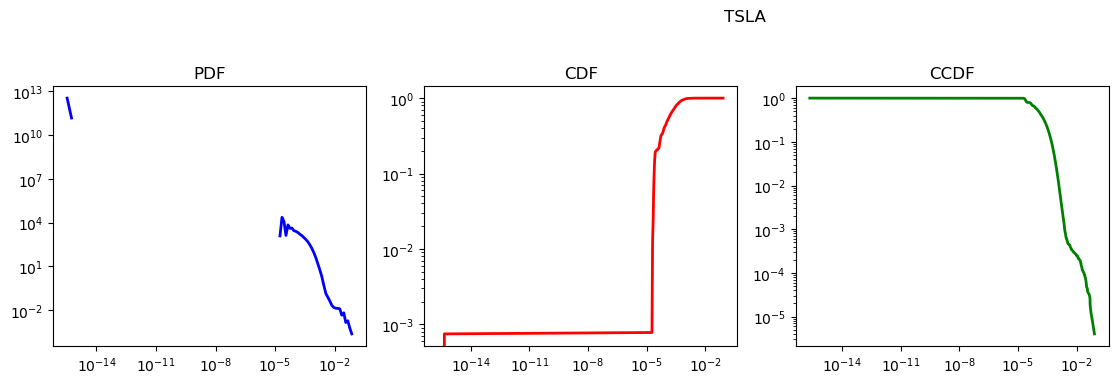

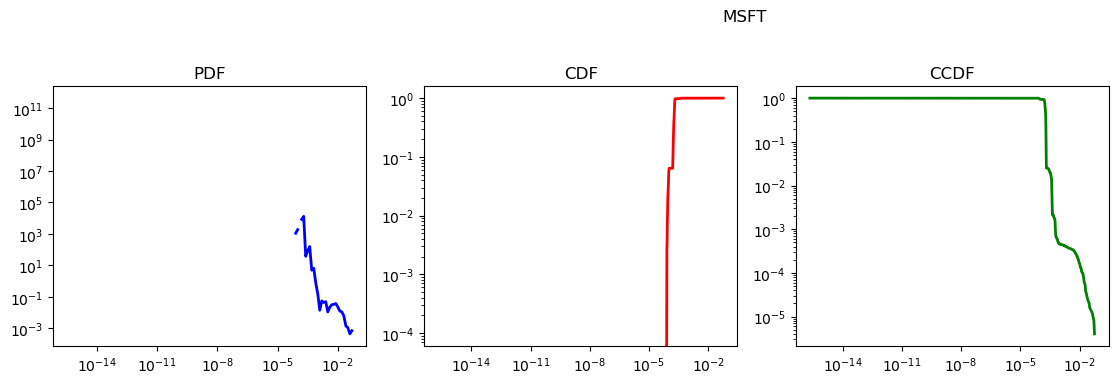

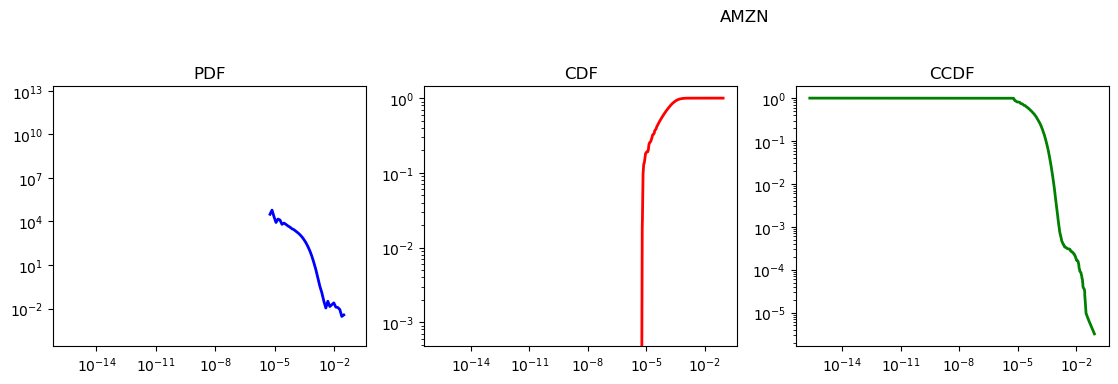

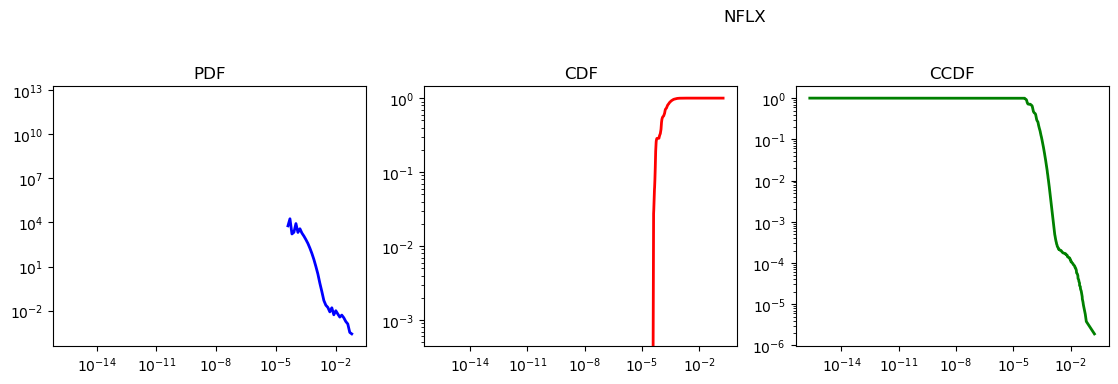

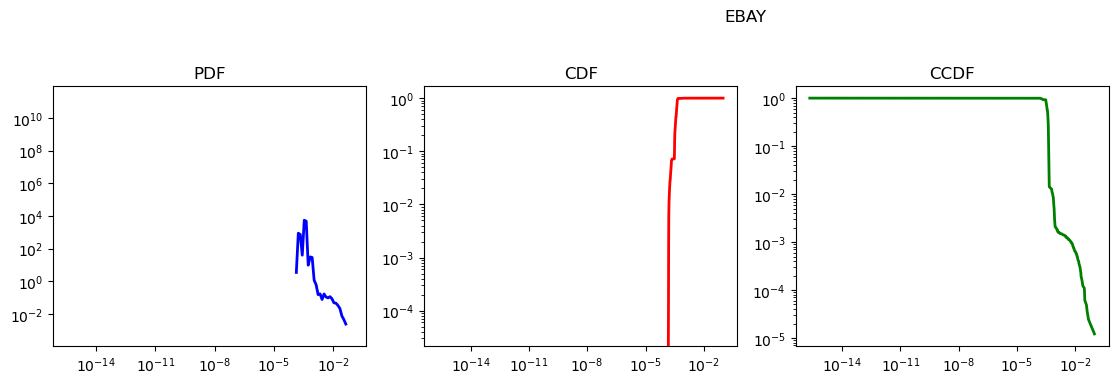

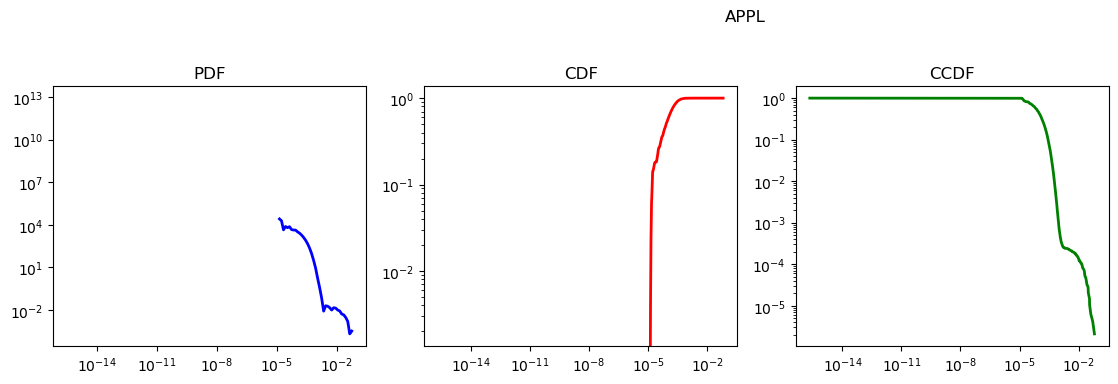

In [18]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in percentage_returns.items():
    plot_distributions(stock_name, data)

### 2.3. Fit power law distribution to percentage returns

In [19]:
# 1. Fit Powerlaw and retrieve fitted object/ results
percentage_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_percentage_returns_distributions.pkl')

if not os.path.exists(percentage_returns_distributions_data):
    percentage_returns_fit_objects = fit_powerlaw(data_dict=percentage_returns, filename=percentage_returns_distributions_data)
else:
    percentage_returns_fit_objects = load_fit_objects(percentage_returns_distributions_data)

percentage_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x3072b5750>,
 'MSFT': <powerlaw.Fit at 0x2a2534910>,
 'AMZN': <powerlaw.Fit at 0x17bd9c150>,
 'NFLX': <powerlaw.Fit at 0x17bd9f050>,
 'EBAY': <powerlaw.Fit at 0x3072b67d0>,
 'APPL': <powerlaw.Fit at 0x3072b4d90>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

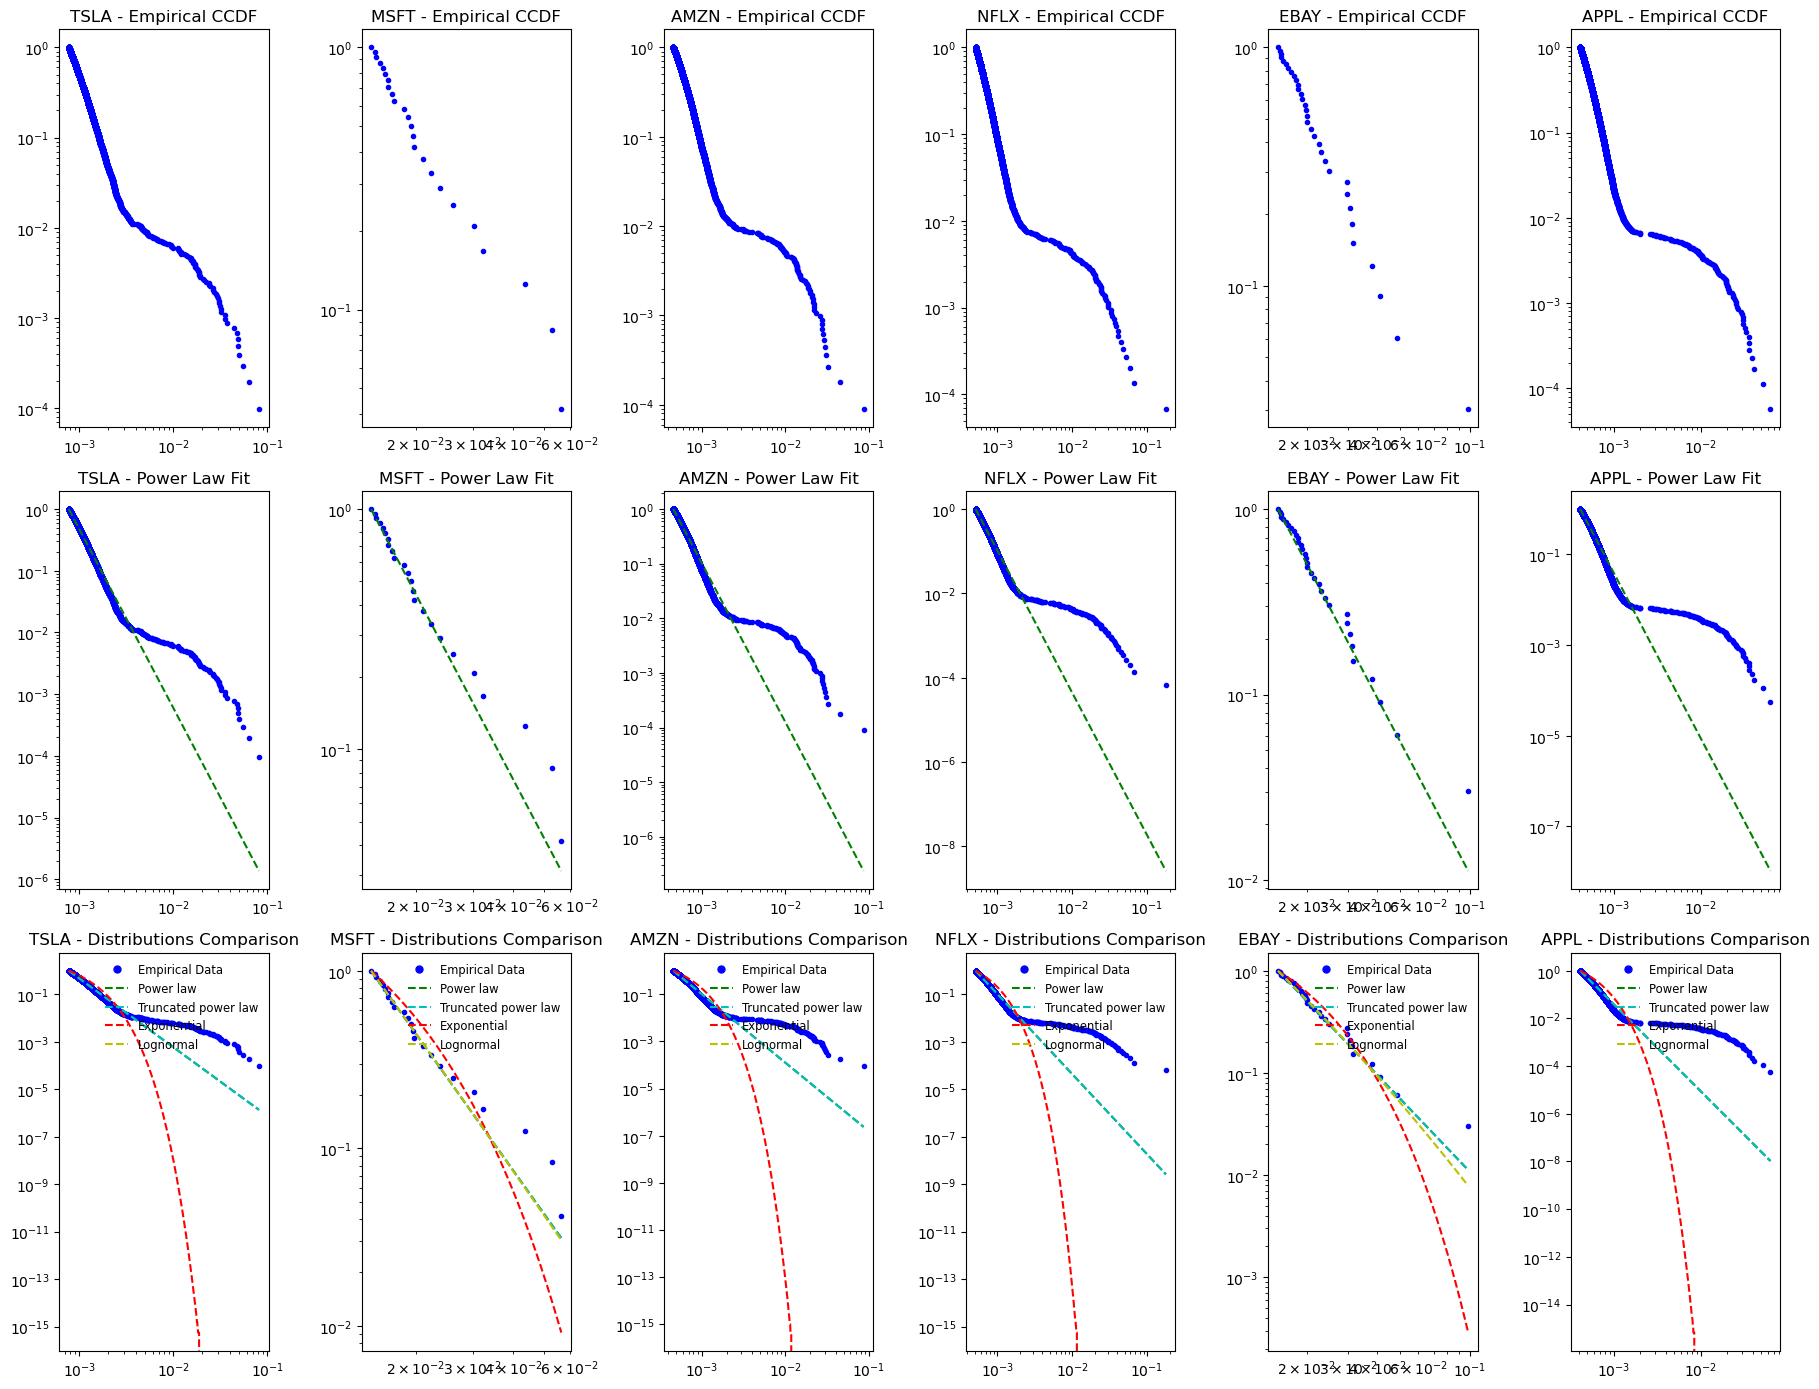

In [20]:
# Plot fitted objects
plot_fit_objects(percentage_returns_fit_objects)

#### 2.3.1. Retrieve Power law fitting results

In [21]:
# Get fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'power_law')
print(percentage_returns_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.897987  0.000771     0.019991
1  MSFT    power_law  3.559261  0.014551     0.064610
2  AMZN    power_law  3.915487  0.000461     0.028275
3  NFLX    power_law  4.378032  0.000514     0.021699
4  EBAY    power_law  3.392282  0.015018     0.075980
5  APPL    power_law  4.645614  0.000413     0.025114


In [22]:
# Average Alpha exponents across stocks
min_alpha = percentage_returns_results['alpha'].min()
max_alpha = percentage_returns_results['alpha'].max()
avg_alpha = percentage_returns_results['alpha'].mean()
std_dev_alpha = percentage_returns_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.39228225304039
Max Alpha: 4.645613648183479
Average Alpha: 3.964777344071321
std_dev_alpha: 0.476109607507337


In [23]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'truncated_power_law')
print(percentage_returns_results)

  Stock         Distribution     alpha    Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  3.897968  0.000009  0.000771     0.019992
1  MSFT  truncated_power_law  3.253830  8.662451  0.014551     0.067592
2  AMZN  truncated_power_law  3.915521  0.000003  0.000461     0.028272
3  NFLX  truncated_power_law  4.377869  0.000006  0.000514     0.021712
4  EBAY  truncated_power_law  3.100977  7.488057  0.015018     0.072052
5  APPL  truncated_power_law  4.645440  0.000007  0.000413     0.025124


In [24]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'exponential')
print(percentage_returns_results)

  Stock Distribution       Lambda      xmin  KS Distance
0  TSLA  exponential  1993.895885  0.000771     0.162308
1  MSFT  exponential   112.164350  0.014551     0.145147
2  AMZN  exponential  3151.428930  0.000461     0.181532
3  NFLX  exponential  3232.188057  0.000514     0.197939
4  EBAY  exponential    98.067612  0.015018     0.123586
5  APPL  exponential  4417.271758  0.000413     0.193345


#### 2.3.2. Compare Alternative Distributions

In [25]:
# Compare against alternative heavy-tailed distributions
percentage_returns_powerlaw_exponential = distribution_compare(percentage_returns_fit_objects, 'exponential')
display(percentage_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,1993.895885,0.000771,3.897987,0.019991,0.162308,8.536606,1.382221e-17
1,MSFT,exponential,112.164350,0.014551,3.559261,0.064610,0.145147,1.126268,2.600520e-01
2,AMZN,exponential,3151.428930,0.000461,3.915487,0.028275,0.181532,9.031559,1.692435e-19
3,NFLX,exponential,3232.188057,0.000514,4.378032,0.021699,0.197939,7.809402,5.745997e-15
4,EBAY,exponential,98.067612,0.015018,3.392282,0.075980,0.123586,0.798590,4.245284e-01
5,APPL,exponential,4417.271758,0.000413,4.645614,0.025114,0.193345,10.322394,5.581401e-25


## 3. Log Returns

In [26]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df, )['log_returns']
msft_log_returns = compute_returns(msft_raw_df, )['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df,)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df, )['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df,)['log_returns']
appl_log_returns = compute_returns(appl_raw_df,)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'APPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### 3.1. Stationarity Test

In [27]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -350.98
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.60
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.79
p-value: 0.00,
N: 499993, 
critical values: {'1%': -3.4303630788502493, '5%': -2.8615457806978664, '10%': -2.566773076854312}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


### 3.2. Log return density functions

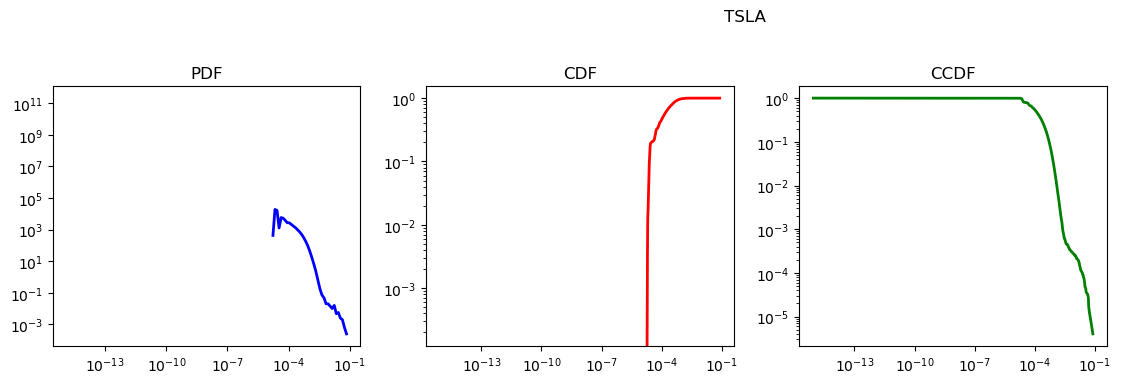

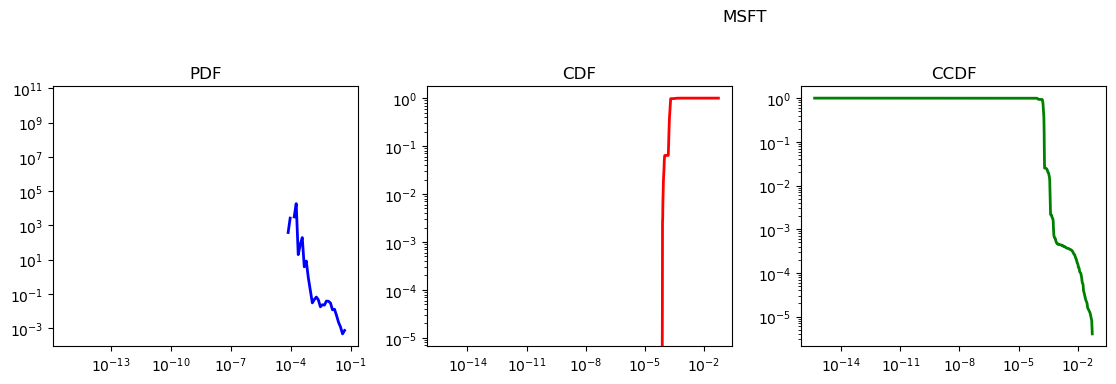

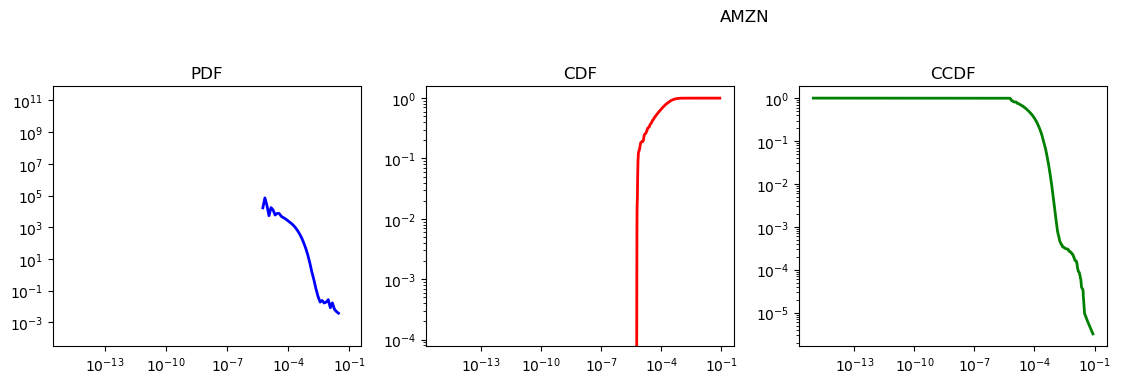

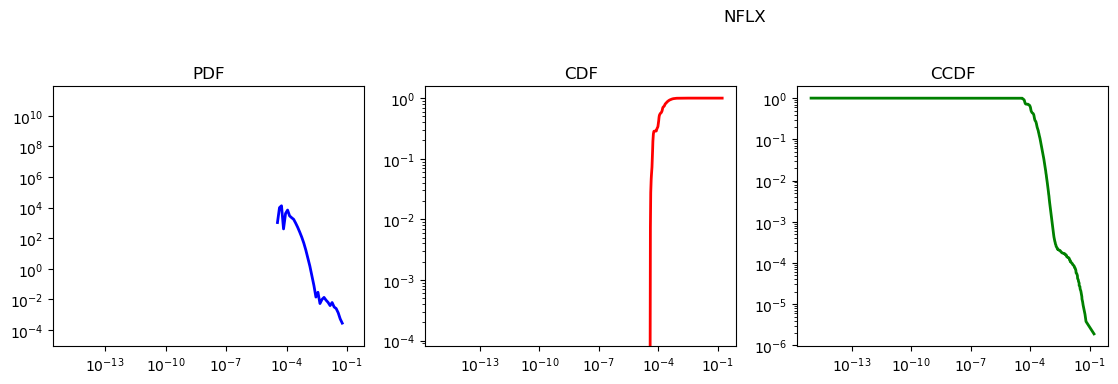

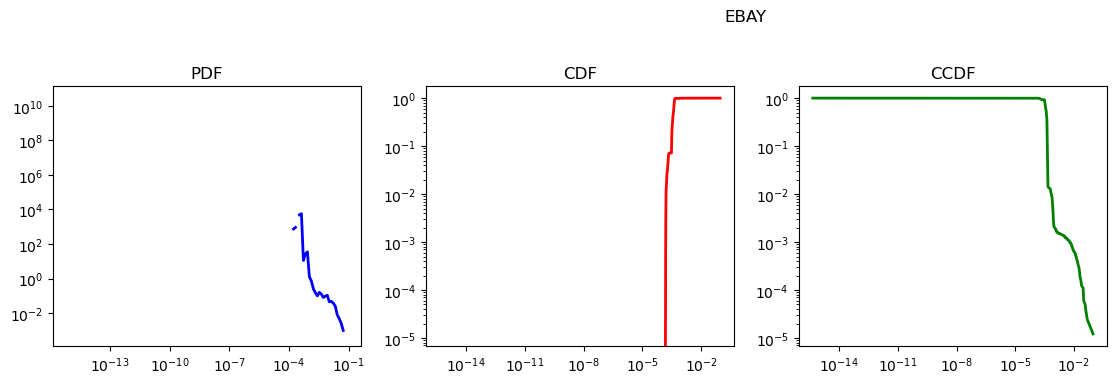

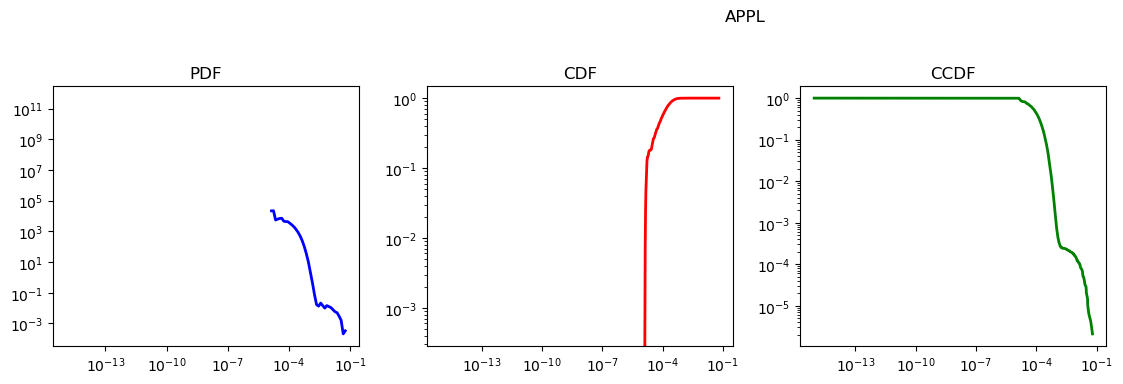

In [28]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in log_returns.items():
    plot_distributions(stock_name, data)

### 3.3. Fit power law distribution to log returns

In [29]:
# 1. Fit Powerlaw and retrieve fitted object/ results
log_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_log_returns_distributions.pkl')

if not os.path.exists(log_returns_distributions_data):
    log_returns_fit_objects = fit_powerlaw(data_dict=log_returns, filename=log_returns_distributions_data)
else:
    log_returns_fit_objects = load_fit_objects(log_returns_distributions_data)

log_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x2a3b4b690>,
 'MSFT': <powerlaw.Fit at 0x2eddb2c50>,
 'AMZN': <powerlaw.Fit at 0x2a3b48790>,
 'NFLX': <powerlaw.Fit at 0x2a3b4ad50>,
 'EBAY': <powerlaw.Fit at 0x2a405d750>,
 'APPL': <powerlaw.Fit at 0x16a097010>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

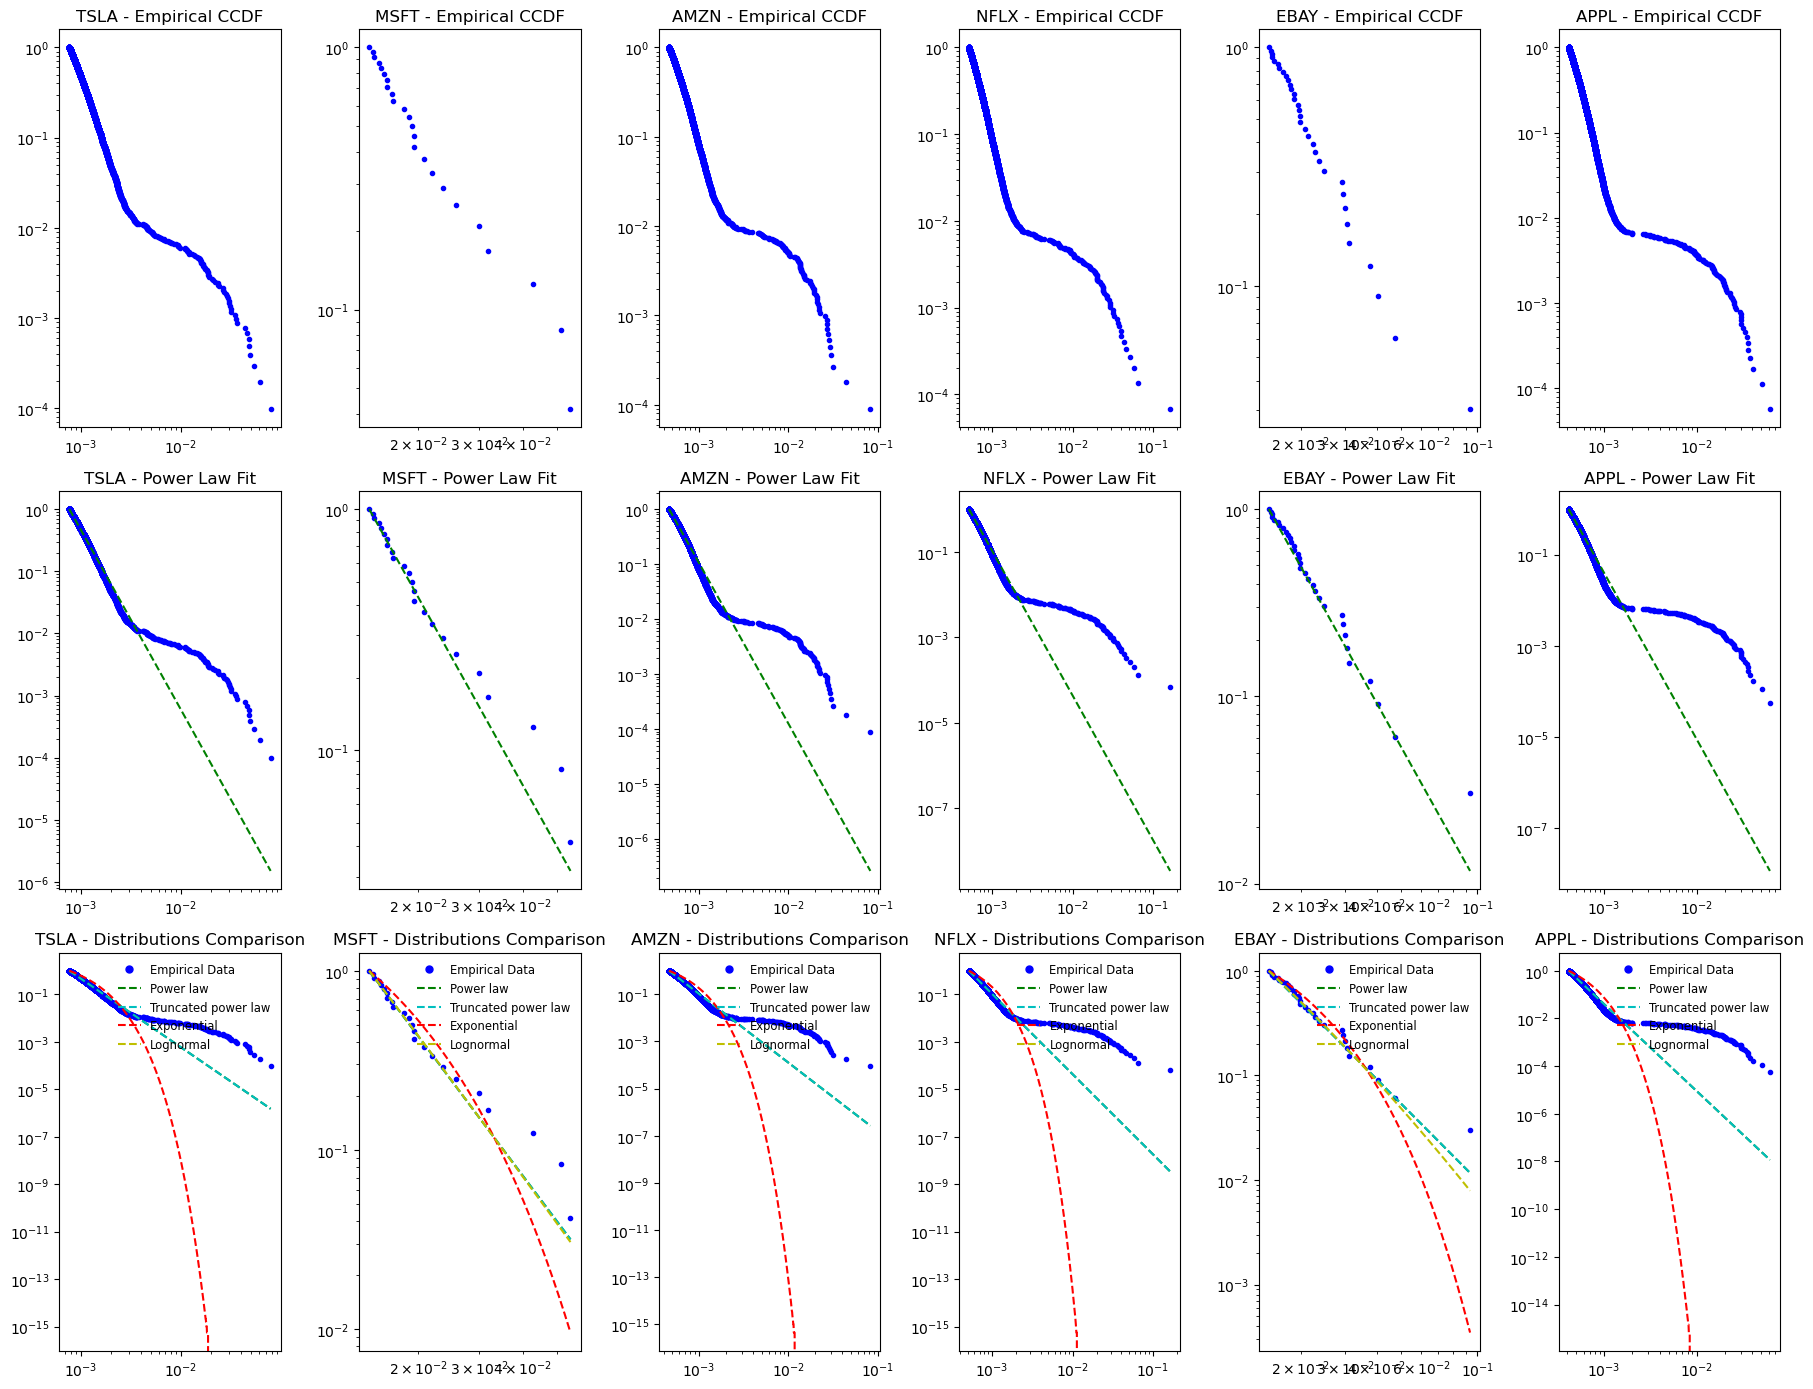

In [30]:
# Plot fitted objects
plot_fit_objects(log_returns_fit_objects)

#### 3.3.1. Retrieve Power law fitting results

In [31]:
# Get fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'power_law')
print(log_returns_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.900085  0.000770     0.019955
1  MSFT    power_law  3.588156  0.014446     0.064308
2  AMZN    power_law  3.916831  0.000461     0.028248
3  NFLX    power_law  4.379786  0.000514     0.021724
4  EBAY    power_law  3.421069  0.014907     0.076411
5  APPL    power_law  4.647112  0.000413     0.025091


In [32]:
# Average Alpha exponents across stocks
min_alpha = log_returns_results['alpha'].min()
max_alpha = log_returns_results['alpha'].max()
avg_alpha = log_returns_results['alpha'].mean()
std_dev_alpha = log_returns_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.4210690952420033
Max Alpha: 4.647112246878876
Average Alpha: 3.9755066041379905
std_dev_alpha: 0.4649877884786065


In [33]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'truncated_power_law')
print(log_returns_results)

  Stock         Distribution     alpha    Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  3.900210  0.000003  0.000770     0.019944
1  MSFT  truncated_power_law  3.258138  9.567543  0.014446     0.067468
2  AMZN  truncated_power_law  3.916865  0.000003  0.000461     0.028245
3  NFLX  truncated_power_law  4.379622  0.000006  0.000514     0.021709
4  EBAY  truncated_power_law  3.081694  8.985953  0.014907     0.072168
5  APPL  truncated_power_law  4.646939  0.000007  0.000413     0.025100


In [34]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'exponential')
print(log_returns_results)

  Stock Distribution       Lambda      xmin  KS Distance
0  TSLA  exponential  2005.198916  0.000770     0.160745
1  MSFT  exponential   115.113083  0.014446     0.142234
2  AMZN  exponential  3166.126204  0.000461     0.180144
3  NFLX  exponential  3259.715898  0.000514     0.195308
4  EBAY  exponential   101.108519  0.014907     0.119601
5  APPL  exponential  4439.880254  0.000413     0.191763


#### 3.3.2. Compare Alternative Distributions

In [35]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
log_returns_powerlaw_exponential = distribution_compare(log_returns_fit_objects, 'exponential')
display(log_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,2005.198916,0.000770,3.900085,0.019955,0.160745,8.578761,9.590050e-18
1,MSFT,exponential,115.113083,0.014446,3.588156,0.064308,0.142234,1.085166,2.778481e-01
2,AMZN,exponential,3166.126204,0.000461,3.916831,0.028248,0.180144,9.103021,8.785364e-20
3,NFLX,exponential,3259.715898,0.000514,4.379786,0.021724,0.195308,8.006348,1.181654e-15
4,EBAY,exponential,101.108519,0.014907,3.421069,0.076411,0.119601,0.757461,4.487737e-01
5,APPL,exponential,4439.880254,0.000413,4.647112,0.025091,0.191763,10.347193,4.309367e-25


## 4. Return magnitudes (volatility)

In [36]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'APPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#return_magnitudes = {stock: data.head(1000000) for stock, data in return_magnitudes.items()}

### 4.1. Stationarity Test

In [37]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -49.89
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.43
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -52.60
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -50.20
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 4.2. Volatility density functions

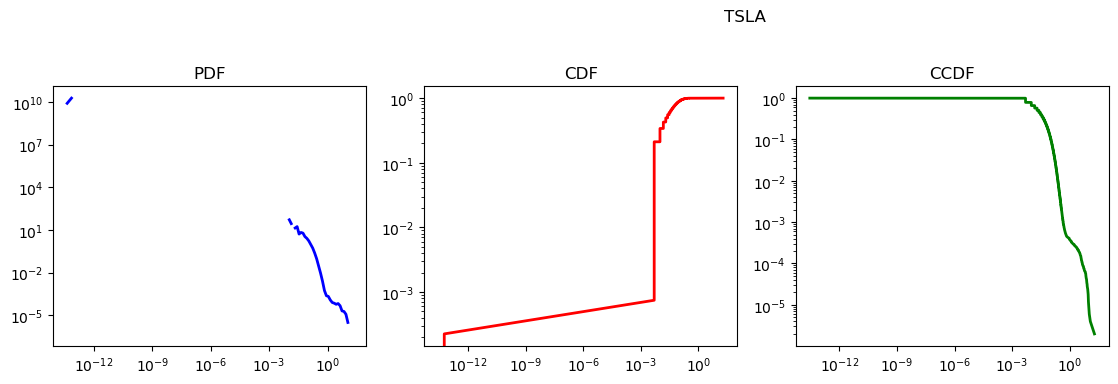

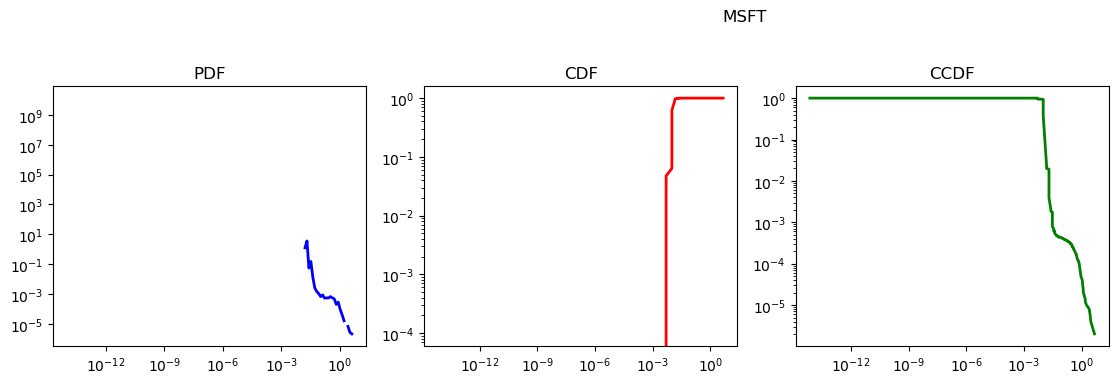

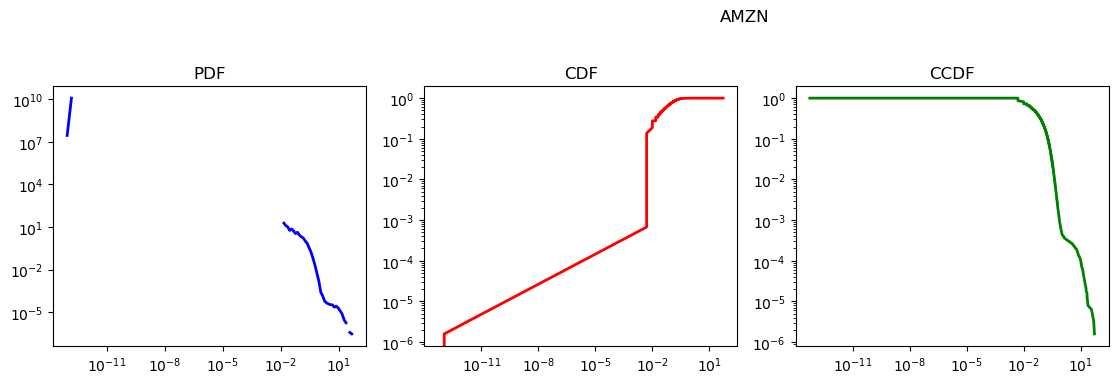

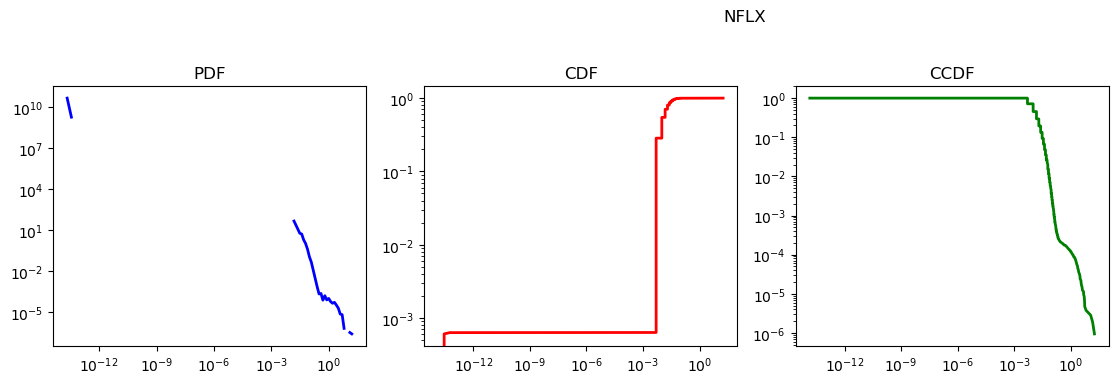

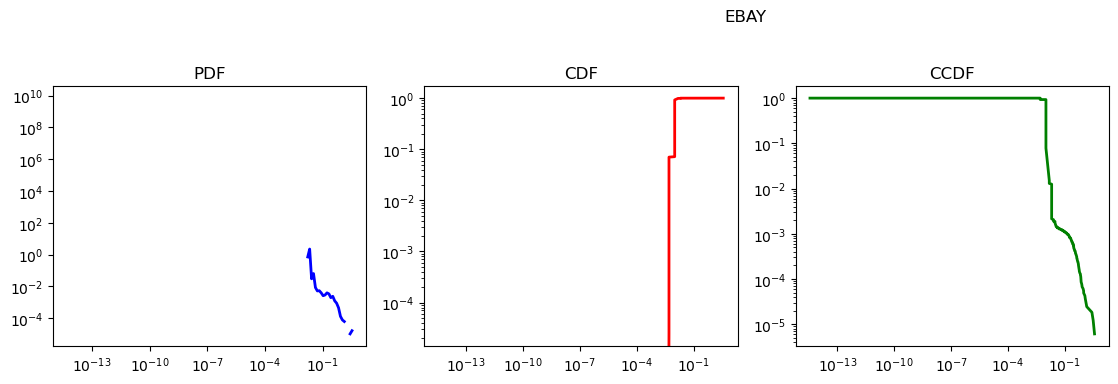

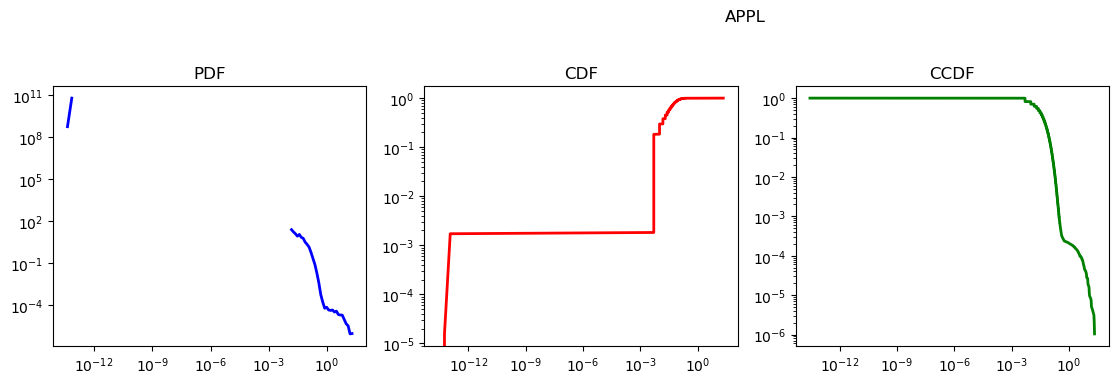

In [38]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in return_magnitudes.items():
    plot_distributions(stock_name, data)

### 4.3. Fit power law distribution to log returns

In [39]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volatility_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volatility_distributions.pkl')

if not os.path.exists(volatility_data):
    volatility_fit_objects = fit_powerlaw(data_dict=return_magnitudes, filename=volatility_data)
else:
    volatility_fit_objects = load_fit_objects(volatility_data)

volatility_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x3072b4c10>,
 'MSFT': <powerlaw.Fit at 0x2a2516c10>,
 'AMZN': <powerlaw.Fit at 0x2a27f77d0>,
 'NFLX': <powerlaw.Fit at 0x2a2a31b10>,
 'EBAY': <powerlaw.Fit at 0x2a29ea490>,
 'APPL': <powerlaw.Fit at 0x169eb1cd0>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

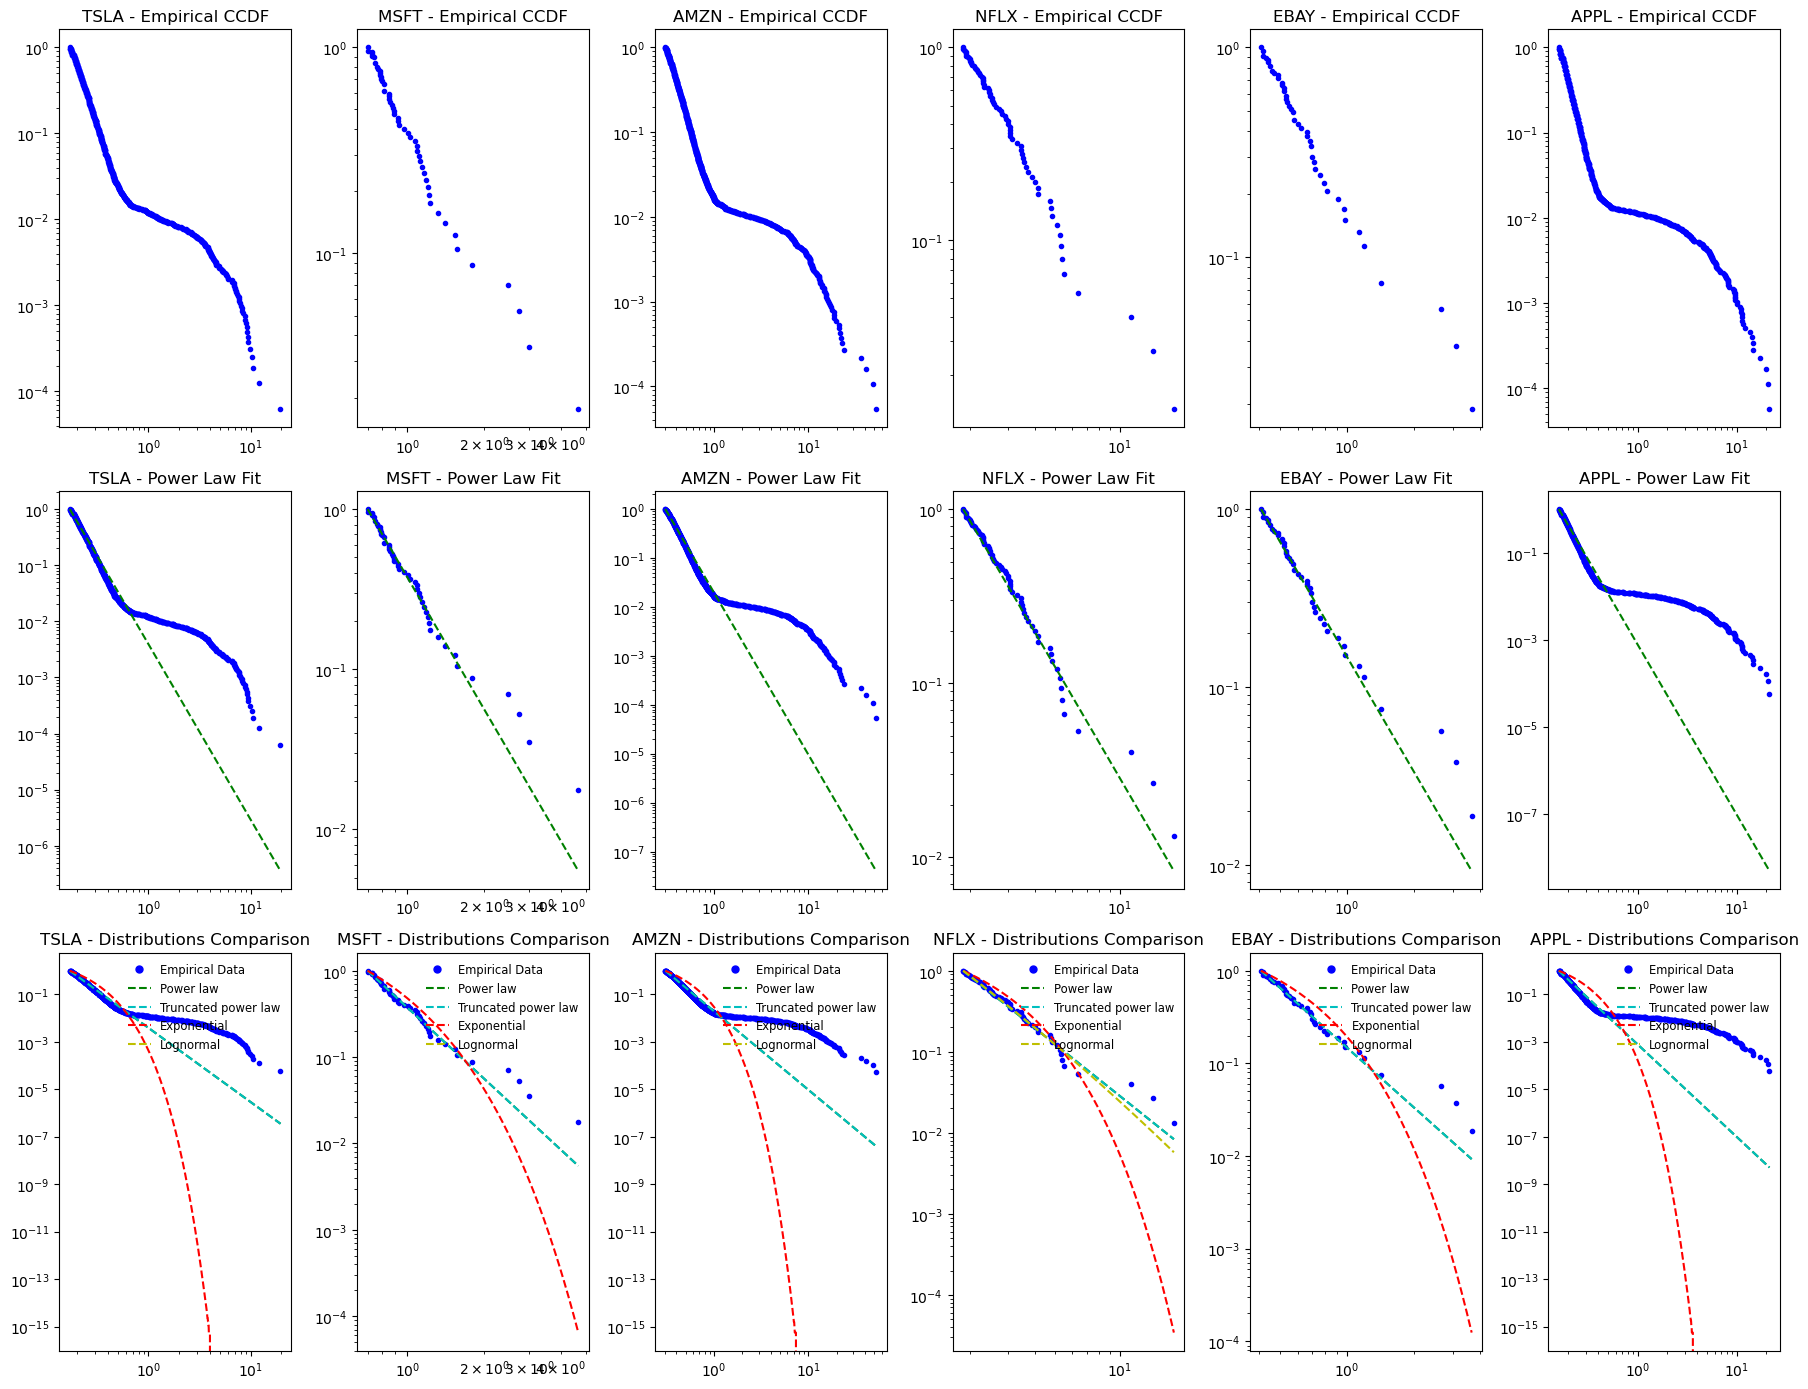

In [40]:
# Plot fitted objects
plot_fit_objects(volatility_fit_objects)

#### 4.3.1. Retrieve Power law fitting results

In [41]:
# Get fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'power_law')
print(volatility_fit_results)

  Stock Distribution     alpha   xmin  KS Distance
0  TSLA    power_law  4.129168  0.170     0.046950
1  MSFT    power_law  3.741539  0.700     0.056192
2  AMZN    power_law  4.308060  0.305     0.032532
3  NFLX    power_law  3.113174  1.855     0.055235
4  EBAY    power_law  3.139655  0.410     0.052937
5  APPL    power_law  4.896344  0.160     0.055694


In [42]:
# Average Alpha exponents across stocks
min_alpha = volatility_fit_results['alpha'].min()
max_alpha = volatility_fit_results['alpha'].max()
avg_alpha = volatility_fit_results['alpha'].mean()
std_dev_alpha = volatility_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.1131743625399455
Max Alpha: 4.896343887263972
Average Alpha: 3.887990176144418
std_dev_alpha: 0.6975951865995764


In [43]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'truncated_power_law')
print(volatility_fit_results)

  Stock         Distribution     alpha        Lambda   xmin  KS Distance
0  TSLA  truncated_power_law  4.129169  3.479781e-08  0.170     0.046950
1  MSFT  truncated_power_law  3.741458  4.488730e-08  0.700     0.056200
2  AMZN  truncated_power_law  4.308055  4.067041e-09  0.305     0.032532
3  NFLX  truncated_power_law  2.928707  3.246685e-02  1.855     0.046984
4  EBAY  truncated_power_law  3.139764  2.076241e-06  0.410     0.052951
5  APPL  truncated_power_law  4.896453  8.125456e-09  0.160     0.055697


In [44]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'exponential')
print(volatility_fit_results)

  Stock Distribution     Lambda   xmin  KS Distance
0  TSLA  exponential   9.328778  0.170     0.204058
1  MSFT  exponential   2.430223  0.700     0.156500
2  AMZN  exponential   5.044200  0.305     0.235782
3  NFLX  exponential   0.642562  1.855     0.120930
4  EBAY  exponential   2.771269  0.410     0.171475
5  APPL  exponential  10.310684  0.160     0.296100


#### 3.3.2. Compare Alternative Distributions

In [45]:
# Compare against alternative heavy-tailed distributions
volatility_powerlaw_exponential = distribution_compare(volatility_fit_objects, 'exponential')
display(volatility_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,9.328778,0.170,4.129168,0.046950,0.204058,13.293234,2.533864e-40
1,MSFT,exponential,2.430223,0.700,3.741539,0.056192,0.156500,1.759675,7.846290e-02
2,AMZN,exponential,5.044200,0.305,4.308060,0.032532,0.235782,13.608954,3.542762e-42
3,NFLX,exponential,0.642562,1.855,3.113174,0.055235,0.120930,1.398784,1.618777e-01
4,EBAY,exponential,2.771269,0.410,3.139655,0.052937,0.171475,2.106569,3.515495e-02
5,APPL,exponential,10.310684,0.160,4.896344,0.055694,0.296100,15.449563,7.595625e-54
